In [1]:
# Import the necessary libraries
import os
import zipfile
import random
import shutil
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
from sklearn.model_selection import train_test_split 
from random import randint
import cv2

In [3]:
source_path = '/Users/mdaniyalk/Documents/github/work/twibbon-ai-findit23/notebook/dataset'

source_path_false = os.path.join(source_path, 'False')
source_path_CTF = os.path.join(source_path, 'CTF')

# Deletes all non-image files (there are two .db files bundled into the dataset)
!find /tmp/PetImages/ -type f ! -name "*.jpg" -exec rm {} +

# Deletes corrupt images files
class_names = ['False', 'CTF']
for _class in class_names:
  folder_path = os.path.join(source_path, _class)
  for img_file in os.listdir(folder_path):
    path = os.path.join(folder_path, img_file)
    try:
      image=cv2.imread(path)
    except:
      print(f'Removing {img_file} in {_class}')
      # os.remove(path)

# os.listdir returns a list containing all files under the given path
print(f"There are {len(os.listdir(source_path_false))} images of false.")
print(f"There are {len(os.listdir(source_path_CTF))} images of CTF.")

find: /tmp/PetImages/: No such file or directory
There are 4916 images of false.
There are 4239 images of CTF.


In [4]:
def load_dataset(SOURCE_DIR, CLASS_NAME, TARGET_SIZE):
  """
  Load images and labels from directories
  
  Args:
    SOURCE_DIR (string): directory path containing the images
    CLASS_NAME (array_like): Array of class names
    TARGET_SIZE (array_like): Dimension of the images
    
  Returns:
    array_like: Images data
    array_like: Images label
  """

  dataset = []
  label = []

  for _class in CLASS_NAME:
    tmp_dataset = []
    folder_path = os.path.join(SOURCE_DIR, _class)
    for img_file in os.listdir(folder_path):
      path = os.path.join(folder_path, img_file)
      try:
        image=cv2.imread(path)
      except:
        print(f'File {img_file} in {_class} is corrupted')
      else:
        img=cv2.imread(path)
        image = cv2.resize(img, dsize=TARGET_SIZE, interpolation=cv2.INTER_AREA)
        image=np.array(image)
        tmp_dataset.append(image)
        del image
        label.append(_class)
    dataset.append(np.asarray(tmp_dataset))
    del tmp_dataset
  dataset = np.concatenate(dataset, axis=0)
  
  # Label converter
  labels = []
  for _label in label:
    labels.append(CLASS_NAME.index(_label))
    
  # One hot encoder for multiple classes
  if len(CLASS_NAME) > 2:
    labels = tf.keras.utils.to_categorical(labels).astype(int)
  del label

  return dataset, np.asarray(labels)

In [6]:
class_name = ['False', 'CTF']
dataset, labels = load_dataset(source_path, class_name, (224,224))

In [7]:
# Checking dataset and labels shape
print(dataset.shape)
print(labels.shape)

(9155, 224, 224, 3)
(9155,)


In [8]:
# Train test split
train_data, test_data, label_train, label_test = train_test_split(dataset, labels, train_size=0.99, shuffle=True)

In [9]:
# Checking train, test, and it's label shape
print(train_data.shape)
print(label_train.shape)
print(test_data.shape)
print(label_test.shape)

(9063, 224, 224, 3)
(9063,)
(92, 224, 224, 3)
(92,)


In [14]:
def create_model():

  model = tf.keras.models.Sequential([ 
      tf.keras.layers.Lambda(lambda x: x/255, input_shape=(224, 224, 3)), # Normalize the input images
      tf.keras.layers.Conv2D(16, (5,5), activation='relu'),
      tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
      tf.keras.layers.MaxPooling2D(2,2),
      tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
      tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
      tf.keras.layers.MaxPooling2D(2,2),
      # tf.keras.layers.BatchNormalization(), # Uncomment to use BatchNormalization
      tf.keras.layers.GlobalAveragePooling2D(),
      # tf.keras.layers.Flatten(), # If you use GlobalAveragePooling, comment this line
      tf.keras.layers.Dense(256, activation='relu'),
      tf.keras.layers.Dropout(0.2), # Uncomment to use dropout
      tf.keras.layers.Dense(1, activation='sigmoid', name="output")
  ])

  
  model.compile(loss='binary_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              metrics=['accuracy'])
    

  return model

In [15]:
# Get the untrained model
# tf.keras.backend.set_floatx('float16')

model = create_model()

In [16]:
# Display model architecture
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda_1 (Lambda)           (None, 224, 224, 3)       0         
                                                                 
 conv2d_4 (Conv2D)           (None, 220, 220, 16)      1216      
                                                                 
 conv2d_5 (Conv2D)           (None, 218, 218, 32)      4640      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 109, 109, 32)     0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 107, 107, 64)      18496     
                                                                 
 conv2d_7 (Conv2D)           (None, 105, 105, 128)     73856     
                                                      

In [17]:
# Train the model
# Note that this may take some time.
history = model.fit(train_data, label_train,batch_size=64, validation_split=0.2, epochs=5)

Epoch 1/5


2023-02-28 02:02:53.468724: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


114/114 [==============================] - ETA: 0s - loss: 0.2702 - accuracy: 0.8756

2023-02-28 02:04:16.416222: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


114/114 [==============================] - 90s 766ms/step - loss: 0.2702 - accuracy: 0.8756 - val_loss: 0.0731 - val_accuracy: 0.9868
Epoch 2/5
114/114 [==============================] - 89s 782ms/step - loss: 0.0625 - accuracy: 0.9886 - val_loss: 0.0660 - val_accuracy: 0.9901
Epoch 3/5
114/114 [==============================] - 85s 748ms/step - loss: 0.0657 - accuracy: 0.9880 - val_loss: 0.0333 - val_accuracy: 0.9917
Epoch 4/5
114/114 [==============================] - 94s 823ms/step - loss: 0.0382 - accuracy: 0.9928 - val_loss: 0.0247 - val_accuracy: 0.9950
Epoch 5/5
114/114 [==============================] - 86s 750ms/step - loss: 0.0302 - accuracy: 0.9941 - val_loss: 0.0244 - val_accuracy: 0.9956


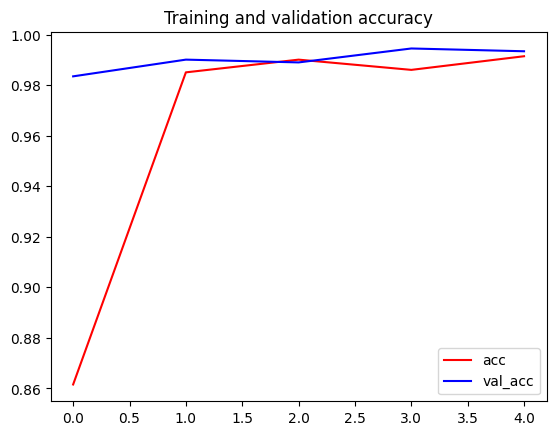

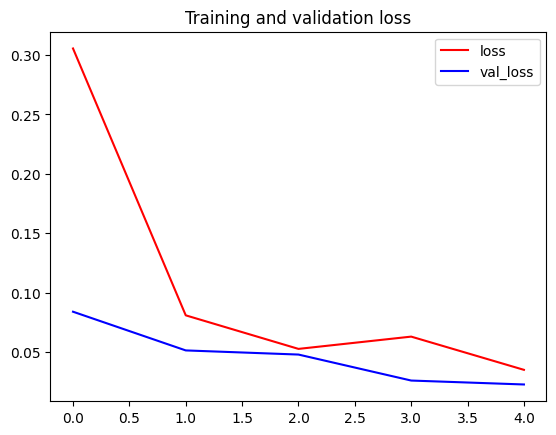

In [12]:
# Retrieve a list of list results on training and test data
# sets for each training epoch
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

# Plot training and validation accuracy per epoch
plt.plot(epochs, acc, 'r', label='acc')
plt.plot(epochs, val_acc, 'b', label='val_acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.show()
print("")

# Plot training and validation loss per epoch
plt.plot(epochs, loss, 'r', label='loss')
plt.plot(epochs, val_loss, 'b', label='val_loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [18]:
import timeit
time = []
for data in test_data:
    start = timeit.default_timer()
    data = np.expand_dims(data, axis=0)
    
    model.predict(data)
    end = timeit.default_timer()
    time.append(end - start)

2023-02-28 02:10:16.956769: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 16ms/step


In [19]:
print(f"Max time= {np.max(np.array(time))}")
print(f"Min time= {np.min(np.array(time))}")
print(f"Avg time= {np.average(np.array(time))}")

Max time= 0.6847050827927887
Min time= 0.03002708265557885
Avg time= 0.04633940264845834


In [25]:
a =model.predict(data)
a.shape

1/1 [==============================] - 0s 61ms/step


(1, 1)

In [35]:
int(np.round(a.flatten()[0]))

1

In [20]:
model_path = 'model_twibbbon.h5'

In [21]:
model.save(model_path)

In [22]:
from sklearn.metrics import accuracy_score

yhat1 = model.predict(test_data)
yhat1 = np.round(np.array(yhat1))

ytrue = label_test

accuracy2 = accuracy_score(ytrue, yhat1)
print(f'Original model acc on test set={accuracy2}')

3/3 [==============================] - 0s 104ms/step
Original model acc on test set=0.9891304347826086
